In [5]:
%pip install pyagrum
%load_ext autoreload
%autoreload 2

import csv
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import re
import itertools
from model import *
import re

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Init csv and data

In [6]:
VERTICES_FILE = "VERTICES.CSV"
ARCS_FILE = "ARCS.CSV"
TID_FILE = "thid.csv"
SC_ASSOCIATION_FILE = "scAssociation.csv"
IS_SIMPLIFIED = True
TEST_BENEFIT_SC = 0
TEST_THREAT_IMPACT     = 100000







vertices = []
arcs = []
thidProb = {}
#dict containing p(v) of a node 
arcsDict = {}
#dict containing parents of a node 
invArcsDict = {}



def init_data(folder_fn):
  # Get vertices nodes
  with open(folder_fn(VERTICES_FILE)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      v = Vertex(row[0], row[1], row[2], row[3])
      vertices.append(v)
      
  # arc nodes extraction 
  with open(folder_fn(ARCS_FILE)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      [int(i) for i in row]
      arcs.append(row)
      if row[0] in invArcsDict.keys():
        invArcsDict[row[0]].append(row[1])
      else:
        invArcsDict[row[0]] = []
        invArcsDict[row[0]].append(row[1])
      arcsDict[row[1]] = row[-1]
    
  #prelievo informazioni delle thid prob
  with open(folder_data(TID_FILE)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      thidProb[row[0]] = float(row[-1])

#init_data(complete_folder)
if IS_SIMPLIFIED:
  init_data(simplified_folder)
else:
  init_data(complete_folder)


def multiplyList(myList) :
    # Multiply elements one by one
    result = 1
    for x in myList:
         result = result * x
    return result




# Helper functions

# Bayesian Graph Generation


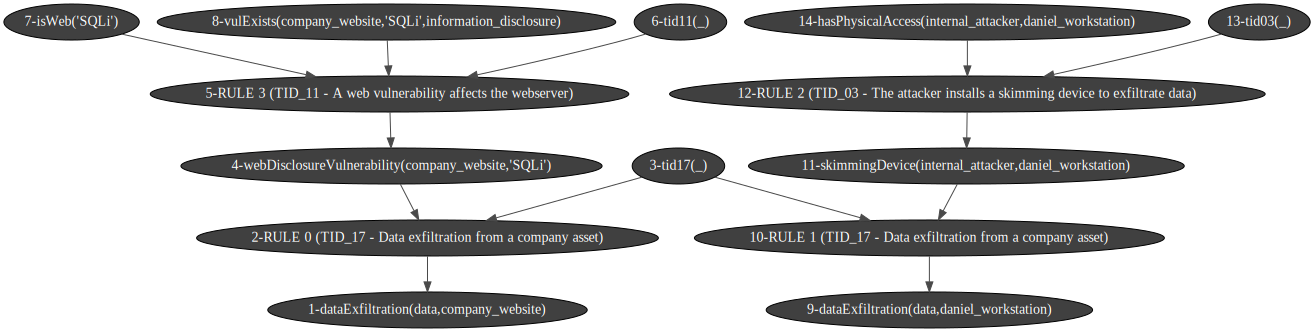

In [22]:
# Bayesian graph generation
bn = gum.BayesNet('BayesianThreatGraph')


# Arc and nodes population
for v in vertices:
  bn.add(gum.LabelizedVariable(v.get_name(), v.text, 2))
  # bn.add(gum.LabelizedVariable(v.id, v.text, 2))


for row in arcs:
  bn.addArc(Vertex.find_by_id(
      vertices, row[1]), Vertex.find_by_id(vertices, row[0]))

# cpt of leaf nodes
for v in vertices:
  if v.is_leaf():
    # cpt of tid nodes
    if v.is_tid():
      tid_id = v.extract_tid_id().upper().replace('TID', 'TID_')
      bn.cpt(v.get_name()).fillWith([1 - thidProb[tid_id], thidProb[tid_id]])
      arcsDict[v.id] = thidProb[tid_id]
    #TO DO assegnazione fittizia degli altri nodi
    else:
      # bn.cpt(row[0]).fillWith([0.5,0.5])
      bn.cpt(v.get_name()).fillWith([0, 1])
      arcsDict[v.id] = 1

while invArcsDict.keys():
  #lista conetente tutti i stati con la cpt calcolata nella seguente iterazione
  assignedState = []

  for key in invArcsDict.keys():
    count = []

    #Falg necessario per comprendere se è stata calcolata o meno la probabilità
    testFlag = False

    #Indivuduazione delle varie componenti che costituiscono la probabilità
    for elem in invArcsDict[key]:
      #condizione che ci permette di sapere se sappiatmo la p(v) di tutti i nodi genitori
      if int(arcsDict[elem]) != -1:
        if vertices[int(key) - 1].is_and():
          count.append(arcsDict[elem])
        if vertices[int(key) - 1].is_or():
          count.append(1 - arcsDict[elem])
      else:
        testFlag = True
        break

    if testFlag == False:
      result = []
      #dizionario fondamentale per creare la cpt
      randomVariables = {}

      #calcolo della probabilità e assegnazione all'interno del dizionario
      probability = multiplyList(count)
      if vertices[int(key) - 1].is_or():
        probability = 1 - probability
      #assegnazione della probabilità calcolata all'interno del dizionario
      arcsDict[key] = probability

      #calcolo di tutte le possibili combinazioni binarie in relazione al numero di genitori del nodo
      combination = [list(i) for i in itertools.product(
          [0, 1], repeat=len(bn.cpt(Vertex.find_by_id(vertices, key)).var_names[:-1]))]

      #crezione di un dizionario da passare come input alla funzione cpt
      for var in bn.cpt(Vertex.find_by_id(vertices, key)).var_names[:-1]:
        randomVariables[var] = 0
      randomVariablesVector = list(randomVariables.keys())

      for elem in combination:
        #assegnazione della singola combinazione e relativa probabilità in base all'operatore
        for iter in range(0, len(elem)):
          randomVariables[randomVariablesVector[iter]] = elem[iter]
        bn.cpt(Vertex.find_by_id(vertices, key))[randomVariables] = [0, 1]
        if vertices[int(key)-1].is_or():
          bn.cpt(Vertex.find_by_id(vertices, key))[
              randomVariables] = [1-probability, probability]

      if vertices[int(key)-1].is_and():
        randomVariables = {x: 1 for x in randomVariables}
        bn.cpt(Vertex.find_by_id(vertices, key))[
            randomVariables] = [1-probability, probability]

      if vertices[int(key)-1].is_or():
        randomVariables = {x: 0 for x in randomVariables}
        bn.cpt(Vertex.find_by_id(vertices, key))[randomVariables] = [0, 1]
      assignedState.append(key)
      #print("complete: " + str(probability) + " id: " + key + " condition: " + vertices[int(key)-1][2])
  #eliminazione dall'invArcsDict necessaria per permettere di ottenere la condizione di terminazione del ciclo
  for item in assignedState:
    del invArcsDict[item]

gnb.showBN(bn, size=30)



# Export BTG


In [8]:
gum.saveBN(bn,"btg.bifxml")
print("btg saved")

btg saved


# Test a posteyoir bayesian

In [23]:
# diag=gum.loadID("btg.bifxml")

p("Make inference")
ie=gum.LazyPropagation(bn)
ie.makeInference()
gnb.showCPTs(bn)
with open('output.txt', 'w') as f:
    for i in diag.names():
        f.write(str(ie.posterior(i)))


[+] Make inference


Exception: [pyAgrum] Several evidence/CPT are incompatible together (proba=0): some evidence entered into the Bayes net are incompatible (their joint proba = 0)

#  Influence diagram generation
- internet attack identification 
- eliminate unused SC decision node
- create utility table 

In [5]:
#TO CHECK
import numpy as np
import math


def costFunction(x):
  q = 10.36163292
  m = 0.55216548
  return np.exp(q+m*math.log(x))	


## Print  loss data function 



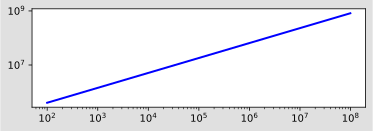

In [6]:
import pylab
import matplotlib.pyplot as plt

def million():
  return pow(10,6)

x = [i for i in range(100, 100* million(), million())]
y = [costFunction(i) for i in x]

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line, = ax.plot(x, y, color='blue', lw=2)

ax.set_xscale('log')
ax.set_yscale('log')

pylab.show()

## Add decision nodes

### Helper functions

In [7]:
import os
import csv
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
from IPython.display import display,HTML
import math
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import sys
# print(vertices)
##################### Helper functions
def get_tid(row):
  return row[2]
def get_sc(row):
  return row[0]
def get_sc_descr(row):
  return row[1]

def add_sc_decision_node(diag, sc, descr, scList):
  try:
    diag.addDecisionNode(gum.LabelizedVariable(sc, descr, 2))
    scList.append(sc)
  except Exception as e:
        print("ERROR")
        print(e)
        pass
  return scList


# def tid_graph_list(vertices):
#   # Returns the list of tid in threat graph
#   tidIndex = {}
#   for v in vertices:


#   return list(tidIndex.keys())

def add_decision_arcs(diag, tidToSc):
  threats = Vertex.get_threats(vertices)
  for tid in tidToSc.keys():
    for elem in tidToSc[tid]:
      #TO DO: add decision node here with try catch or appropriate control
      for t in threats:
        if tid == t.tid_id:
          diag.addArc(elem, t.get_name())


## Calculate decision network

In [8]:

print(gum.availableBNExts())
assert 1
#import bayesian attack graph
diag=gum.loadID("btg.bifxml")
# Bayesian graph generation
#gnb.showInfluenceDiagram(diag)

# #take vertices information from csv file 
# with open(VERTICES_FILE) as csv_file:
#   csv_reader = csv.reader(csv_file, delimiter=',')
#   for row in csv_reader:
#     int(row[0])
#     if row[2] == "LEAF":
#       if "tid" in row[1]:
#         row[1] = re.sub("\(.*?\)","", row[1])
#         if row[1] in tidIndex.keys():
#           pass
#         else:
#           tidIndex[row[1]] = row[0]
#     else:
#       vertices.append(row)



scList = []
relevant_sc = []

def init_security_controls():
  security_controls = {}
  sec_object_list = []
  tidToSc = {}
  #take SC information from csv file 
  with open(folder_data(SC_ASSOCIATION_FILE)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      tid_list = get_tid(row).split(',')
      
      security_controls[get_sc(row)] = get_sc_descr(row)
      # TODO ADD REAL IMPACTS AND COSTS
      new_sec_object = SecurityControl(get_sc(row), 1)
      for t in tid_list:
            # Threat impact, benefit
            new_sec_object.add_threat(ThreatImpact(t, TEST_THREAT_IMPACT), TEST_BENEFIT_SC)
      sec_object_list.append(new_sec_object)
            
            
            
      threats = Vertex.get_threats(vertices)
    
      #diag.addDecisionNode(gum.LabelizedVariable(row[0],row[1],2))
      #scList.append(row[0])
      for elem in tid_list:
          for t in threats: 
            if elem == t.tid_id:
              if elem in tidToSc.keys():
                tidToSc[elem].append(get_sc(row))
              else:
                tidToSc[elem] = []
                tidToSc[elem].append(get_sc(row))

  return security_controls, tidToSc, sec_object_list


security_controls, tidToSc, sec_object_list = init_security_controls()
for list_sc in tidToSc.values():
  relevant_sc.extend(list_sc)

relevant_sc = list(set(relevant_sc))
for sc in relevant_sc: 
  # fn(diag, sc, sc_descr)
  scList = add_sc_decision_node(diag, sc, security_controls[sc], scList)

#add_decision_arcs(diag, tidToSc)
diag





bif|dsl|net|bifxml|o3prm|uai
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost: 100000
sc cost: 1
threat benefit: 0
threat cost

(pyAgrum.InfluenceDiagram<double>@0x150bbb600) Influence Diagram{
  chance: 60,
  utility: 0,
  decision: 13,
  arcs: 65,
  domainSize: 10^21.9752
}

## Generate utility nodes

In [9]:
incremental = 1 


# For each threat, find the security controls that address it
graph_threats = Vertex.get_threats(vertices)
tids = [g.tid_id for g in graph_threats]
# Threat with impact
threats = []





### ADD UTILITY NODES ##
for s in sec_object_list:
    addressed_threats = s.addressed_threats
    # For each addresed threat is it is in the graph, add utility nodes
    for a in addressed_threats: 
        if a.threat.tid in tids:
            current_threat_name = Vertex.find_by_threat_id(vertices, a.threat.tid)
            print(current_threat_name)
            # Threat not occurr, sc not applied
 
            diag.addUtilityNode(gum.LabelizedVariable(a.get_name(), a.get_full_name(), 1))
            diag.addArc(current_threat_name, a.get_name())
            diag.addArc(a.sc.name, a.get_name())
            print(a.get_name())
            diag.utility(a.get_name())[{ current_threat_name : 0, a.sc.name : 0}] = a.sc_no_implemented_no_threat()
            # threat occurr sc not applied
            diag.utility(a.get_name())[{ current_threat_name : 1, a.sc.name : 0}] = a.sc_no_implemented_threat()
            # threat not occurr sc  applied
            diag.utility(a.get_name())[{ current_threat_name : 0, a.sc.name : 1}] = a.sc_implemented_no_threat()
            # threat  occurr sc  applied
            diag.utility(a.get_name())[{ current_threat_name : 1, a.sc.name : 1}] = a.sc_implemented_threat()
            


6-tid06(_)
CIS_03-against-tid06
26-tid10(_)
CIS_03-against-tid10
58-tid05(_)
CIS_04-against-tid05
39-tid04(_)
CIS_06-against-tid04
14-tid11(_)
CIS_07-against-tid11
58-tid05(_)
CIS_07-against-tid05
14-tid11(_)
CIS_09-against-tid11
55-tid02(_)
CIS_10-against-tid02
14-tid11(_)
CIS_12-against-tid11
58-tid05(_)
CIS_12-against-tid05
45-tid08(_)
CIS_14-against-tid08
26-tid10(_)
CIS_14-against-tid10
14-tid11(_)
CIS_14-against-tid11
14-tid11(_)
CIS_16-against-tid11
39-tid04(_)
OTH_01-against-tid04
39-tid04(_)
OTH_02-against-tid04
31-tid01(_)
OTH_03-against-tid01
31-tid01(_)
OTH_04-against-tid01
14-tid11(_)
OTH_04-against-tid11


## Show influence diagram

In [10]:
diag.utility("CIS_12-against-tid11")

(pyAgrum.Potential<double>@0x6000022ba900) 
             ||  CIS_12-|
14-tid|CIS_12||0        |
------|------||---------|
0     |0     || 0.0000  |
1     |0     || -100000.0000|
0     |1     || -1.0000 |
1     |1     || -100001.0000|

{'mean': -326470.40142745635, 'variance': 21611955925.173546}


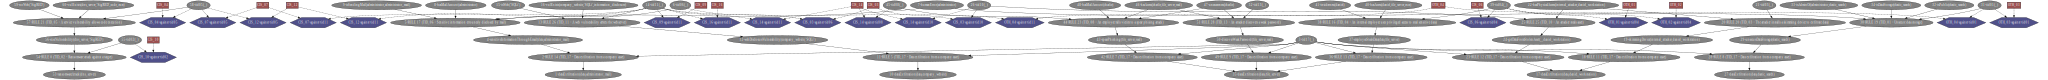

In [11]:
ie=gum.ShaferShenoyLIMIDInference(diag)
ie.makeInference()
print(ie.MEU())
gnb.showInfluenceDiagram(diag,size="40")
#gnb.showInference(diag, size=20) 


### Alternative diagram  

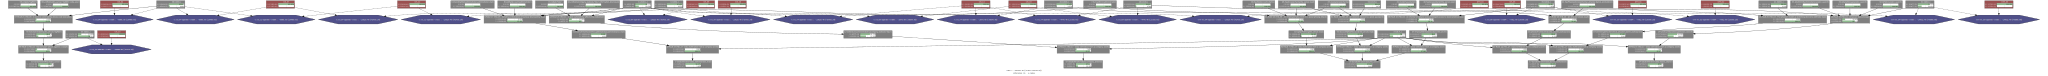

['CIS_03', 'CIS_16', 'OTH_03', 'CIS_10', 'CIS_04', 'CIS_12', 'CIS_09', 'CIS_14', 'OTH_01', 'CIS_07', 'OTH_04', 'CIS_06', 'OTH_02']


In [12]:
#ie=gum.ShaferShenoyLIMIDInference(diag)
gnb.showInference(diag, size=40)

# or diag
#ie = gum.ShaferShenoyLIMIDInference(diag)
#ie.addNoForgettingAssumption(relevant_sc)
print(relevant_sc)
#gnb.showInference(ie.reducedLIMID(), evs={'CIS_12' : 1, 'CIS_09': 1, 'CIS_14' : 1, 'CIS_16' : 1, 'OTH_04' : 1, 'CIS_07' : 1}, size=20) 

#gnb.showInference(ie.reducedLIMID(), size=20) 
#gnb.sideBySide(ie.reducedLIMID(),ie.junctionTree(),gnb.getInference(diag,engine=ie))


In [13]:
#gnb.showInfluenceDiagram(diag, size=30)

#gnb.showInference(diag, size=100)
